This notebook shows you how to use your trained model to make predictions on a novel video, detect outliers, merge the outliers with the existing annotation set, and visualize the data output.

In [1]:
import sys
!{sys.executable} -m pip install -U deepposekit

Requirement already up-to-date: deepposekit in c:\users\pranavm\anaconda3\lib\site-packages (0.3.4)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit.io import DataGenerator, VideoReader, VideoWriter
from deepposekit.io.utils import merge_new_images

import tqdm
import time

from scipy.signal import find_peaks

from os.path import expanduser
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'
HOME = HOME +'/Documents/RamanLab'

Load Trained Model

In [3]:
model = load_model(HOME + '/deepposekit-data/datasets/locust/best_model_densenet.h5')

In [4]:
from deepposekit.models import load_model
import tensorflow as tf

predict_model = model.predict_model
predict_model.layers.pop(0) # remove current input layer

inputs = tf.keras.layers.Input((512, 512, 1))
outputs = predict_model(inputs)
predict_model = tf.keras.Model(inputs, outputs)

#x = np.random.randint(0, 255, (16, 512, 512, 1), dtype=np.uint8) 
#prediction = predict_model.predict(x, verbose=True)
model = predict_model

In [5]:
videos = sorted(glob.glob(HOME + '/Data/*.mp4'))
videos

['C:\\Users\\PranavM/Documents/RamanLab/Data\\1.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\WIN_20191009_11_00_36_Pro.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\WIN_20191015_12_07_05_Pro.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\crop.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\cut.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\full.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\posture.mp4']

Test Video

In [6]:
reader = VideoReader(HOME + '/Data/crop.mp4', batch_size=10, gray=True)
frames = reader[0]
reader.close()

True

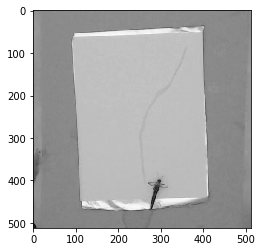

In [7]:
plt.imshow(frames[0,...,0], cmap='gray')
plt.show()

Make Predictions on Full Video

In [8]:
reader = VideoReader(HOME + '/Data/crop.mp4', batch_size=50, gray=True)
predictions = model.predict(reader, verbose=1)
reader.close()

36/36 [==============================] - ETA: 8: - ETA: 4: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 57s - ETA: 53 - ETA: 50 - ETA: 46 - ETA: 43 - ETA: 40 - ETA: 37 - ETA: 34 - ETA: 32 - ETA: 29 - ETA: 26 - ETA: 24 - ETA: 21 - ETA: 19 - ETA: 16 - ETA: 14 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - 83s 2s/step


True

Save Data

In [9]:
np.save(HOME + '/deepposekit-data/datasets/locust/predictions.npy', predictions)

In [10]:
x, y, confidence = np.split(predictions, 3, -1)

C:\Users\PranavM\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


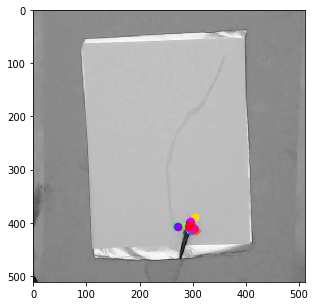

In [11]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/annotation_data_release.h5')

image = frames[0]
keypoints = predictions[0]

plt.figure(figsize=(5,5))
image = image if image.shape[-1] is 3 else image[..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[idx, 0], keypoints[jdx, 0]],
            [keypoints[idx, 1], keypoints[jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[:, 0], keypoints[:, 1],
            c=np.arange(data_generator.keypoints_shape[0]),
            s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

Detect Outlier Frames

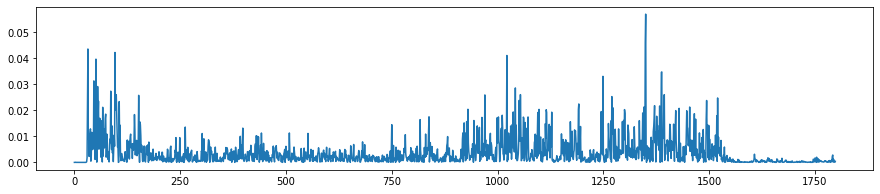

In [12]:
confidence_diff = np.abs(np.diff(confidence.mean(-1).mean(-1)))

plt.figure(figsize=(15, 3))
plt.plot(confidence_diff)
plt.show()

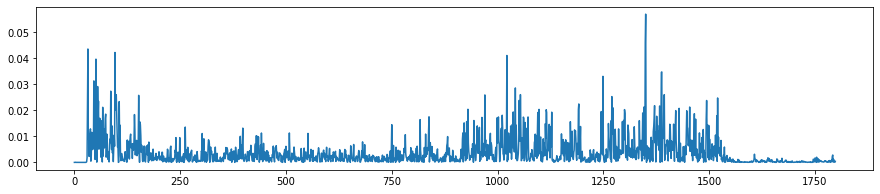

In [13]:
confidence_outlier_peaks = find_peaks(confidence_diff, height=0.1)[0]

plt.figure(figsize=(15, 3))
plt.plot(confidence_diff)
plt.plot(confidence_outlier_peaks, confidence_diff[confidence_outlier_peaks], 'ro')
plt.show()

In [14]:
time_diff = np.diff(predictions[..., :2], axis=0)
time_diff = np.abs(time_diff.reshape(time_diff.shape[0], -1))
time_diff = time_diff.mean(-1)
time_diff.shape

(1799,)

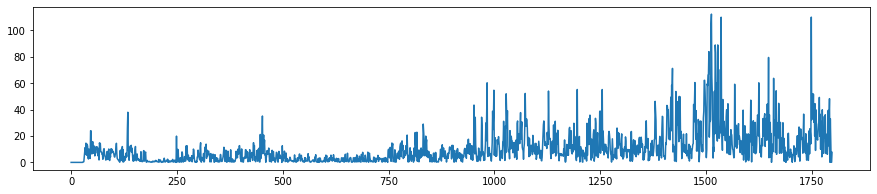

In [15]:
plt.figure(figsize=(15, 3))
plt.plot(time_diff)
plt.show()

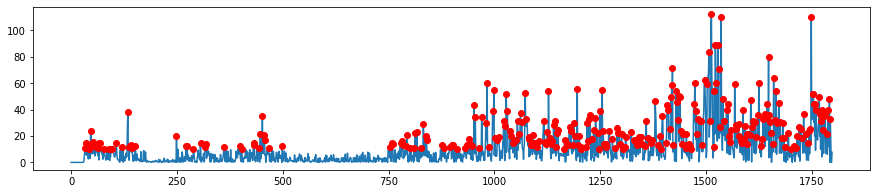

In [16]:
time_diff_outlier_peaks = find_peaks(time_diff, height=10)[0]

plt.figure(figsize=(15, 3))
plt.plot(time_diff)
plt.plot(time_diff_outlier_peaks, time_diff[time_diff_outlier_peaks], 'ro')
plt.show()

In [17]:
outlier_index = np.concatenate((confidence_outlier_peaks, time_diff_outlier_peaks))
outlier_index = np.unique(outlier_index) # make sure there are no repeats

In [18]:
reader = VideoReader(HOME + '/Data/crop.mp4', batch_size=1, gray=True)

outlier_images = []
outlier_keypoints = []
for idx in outlier_index:
    outlier_images.append(reader[idx])
    outlier_keypoints.append(predictions[idx])

outlier_images = np.concatenate(outlier_images)
outlier_keypoints = np.stack(outlier_keypoints)

reader.close()

outlier_images.shape, outlier_keypoints.shape

((301, 512, 512, 1), (301, 35, 3))

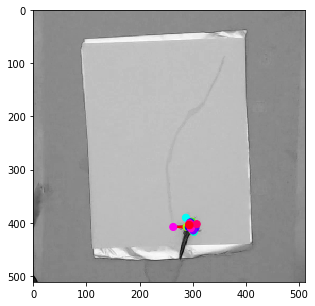

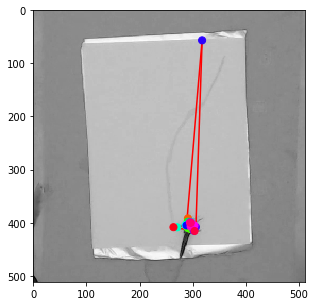

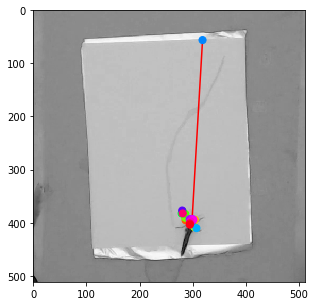

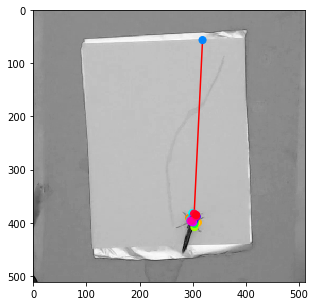

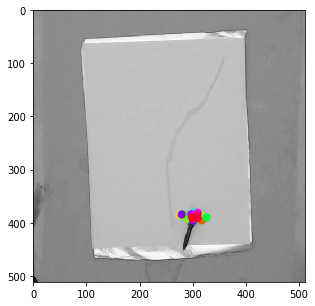

In [19]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/annotation_data_release.h5')

for idx in range(5):
    image = outlier_images[idx]
    keypoints = outlier_keypoints[idx]

    plt.figure(figsize=(5,5))
    image = image if image.shape[-1] is 3 else image[..., 0]
    cmap = None if image.shape[-1] is 3 else 'gray'
    plt.imshow(image, cmap=cmap, interpolation='none')
    for idx, jdx in enumerate(data_generator.graph):
        if jdx > -1:
            plt.plot(
                [keypoints[idx, 0], keypoints[jdx, 0]],
                [keypoints[idx, 1], keypoints[jdx, 1]],
                'r-'
            )
    plt.scatter(keypoints[:, 0], keypoints[:, 1],
                c=np.arange(data_generator.keypoints_shape[0]),
                s=50, cmap=plt.cm.hsv, zorder=3)

    plt.show()

Add outliers to Annotation Set

merge_new_images(
    datapath=HOME + '/deepposekit-data/datasets/locust/annotation_data_release.h5',
    merged_datapath=HOME + '/deepposekit-data/datasets/locust/annotation_data_release_merged.h5',
    images=outlier_images,
    keypoints=outlier_keypoints,
    # overwrite=True # This overwrites the merged dataset if it already exists
)

merged_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/annotation_data_release_merged.h5', mode="unannotated")

image, keypoints = merged_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

In [47]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/annotation_data_release.h5')
predictions = predictions[...,:2]
predictions *= 2

resized_shape = (int(data_generator.image_shape[0]*6.4), int(data_generator.image_shape[1]*6.4))
cmap = plt.cm.hsv(np.linspace(0, 1, data_generator.keypoints_shape[0]))[:, :3][:, ::-1] * 255
cmap
writer = VideoWriter(HOME + '/Data/posture.mp4', (512*2,512*2), 'MP4V', 30.0)
reader = VideoReader(HOME + '/Data/crop.mp4', batch_size=1)

for frame, keypoints in tqdm.tqdm(zip(reader, predictions)):
    frame = frame[0]
    frame = frame.copy()
    frame = cv2.resize(frame, resized_shape)
    for idx, node in enumerate(data_generator.graph):
        if node >= 0:
            pt1 = keypoints[idx]
            pt2 = keypoints[node]
            cv2.line(frame, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0,0,255), 2, cv2.LINE_AA)
    for idx, keypoint in enumerate(keypoints):
        keypoint = keypoint.astype(int)
        cv2.circle(frame, (keypoint[0], keypoint[1]), 5, tuple(cmap[idx]), -1, lineType=cv2.LINE_AA)
        
    writer.write(frame)

writer.close()
reader.close()

1800it [00:15, 117.16it/s]


True

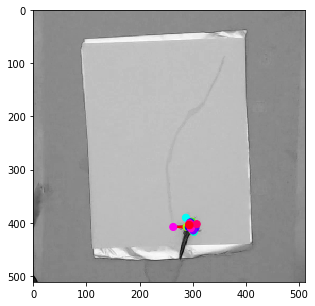

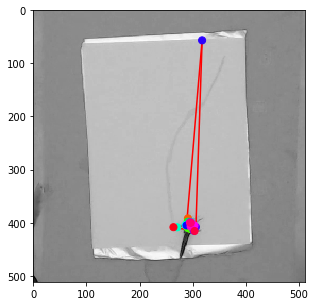

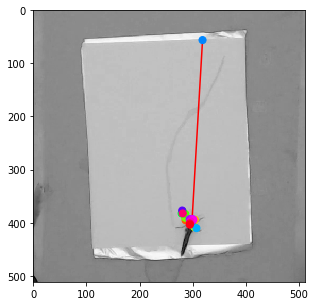

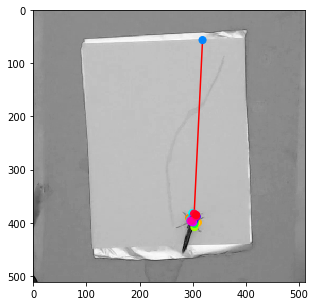

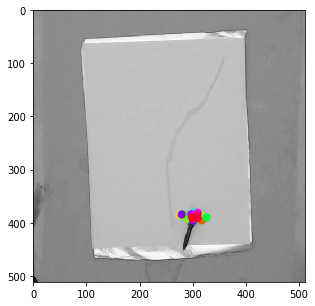

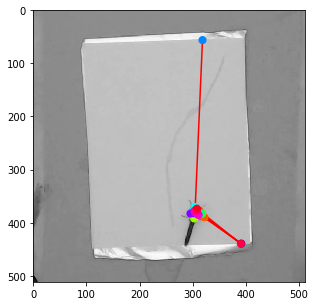

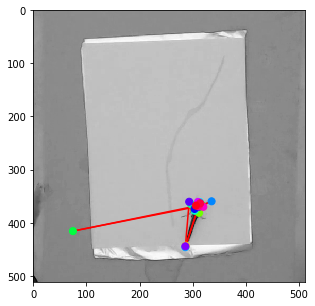

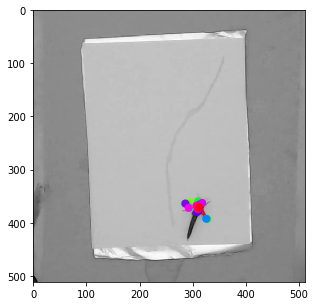

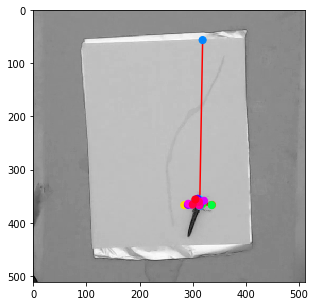

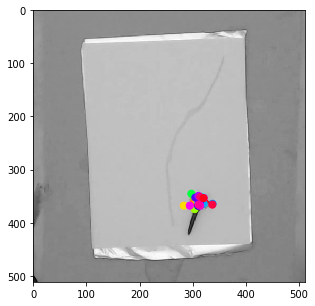

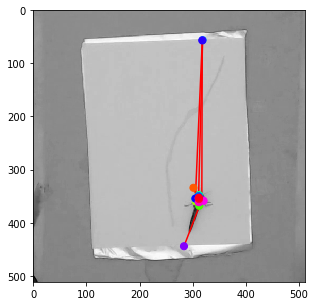

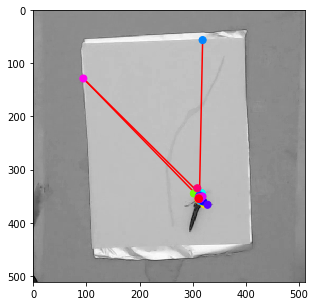

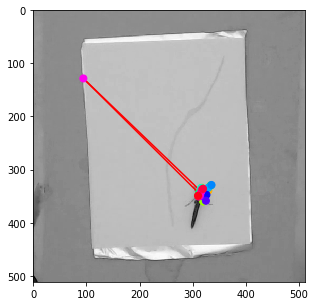

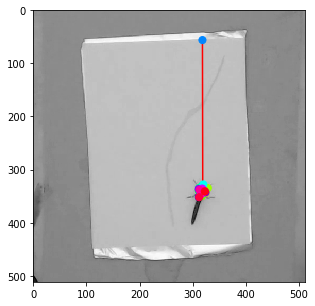

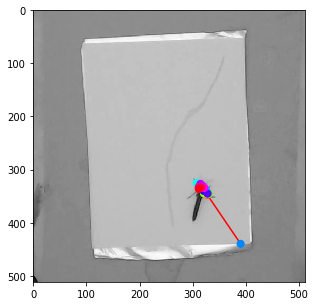

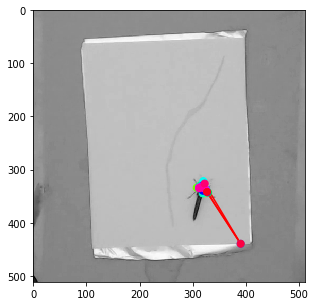

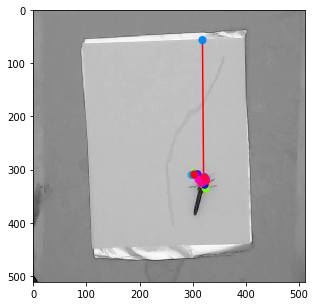

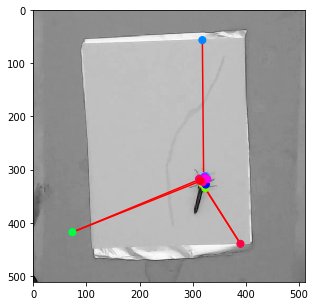

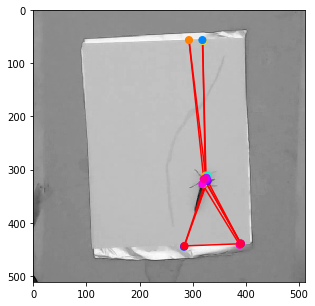

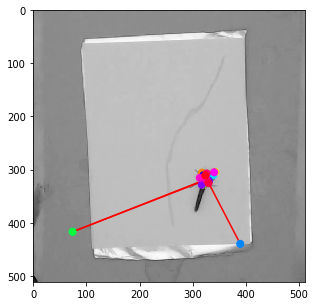

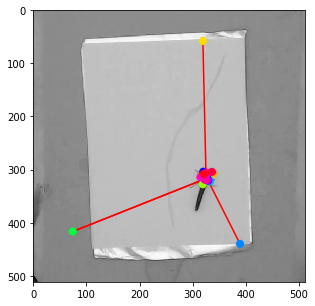

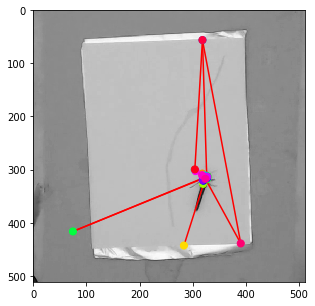

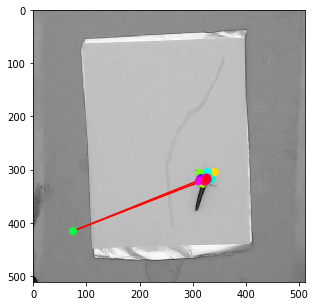

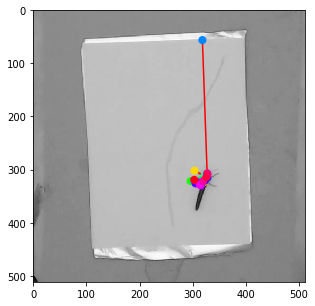

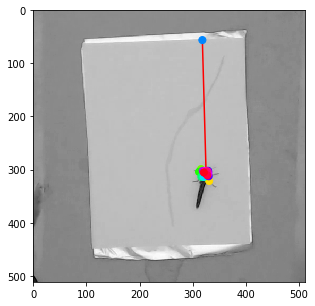

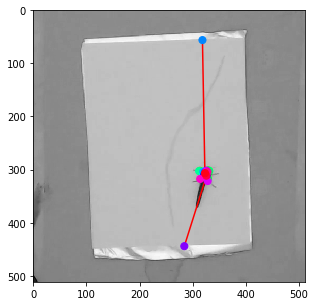

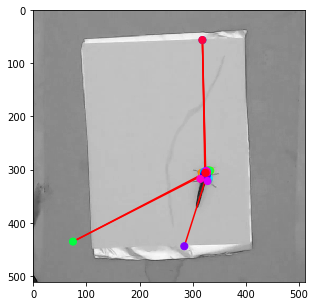

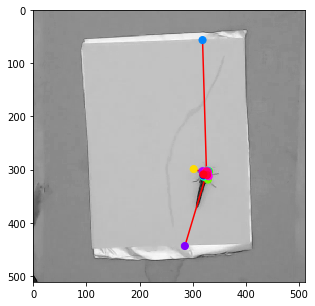

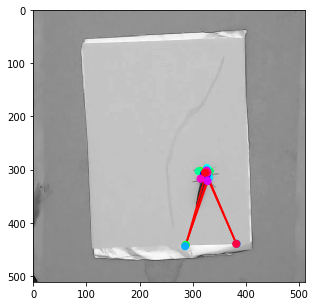

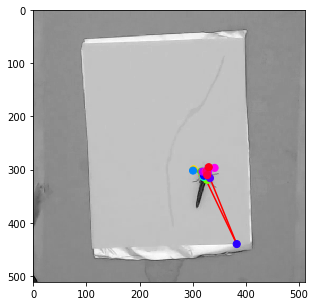

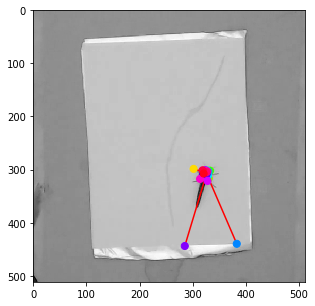

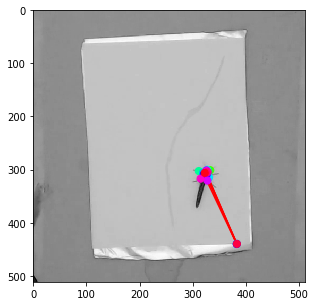

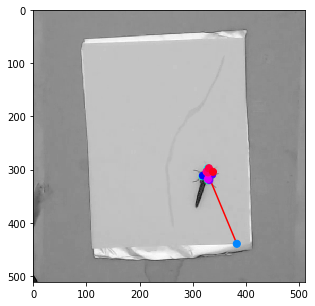

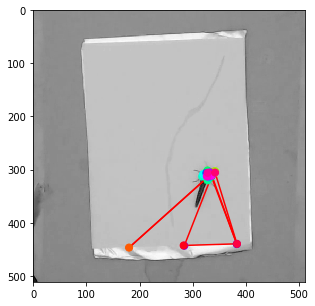

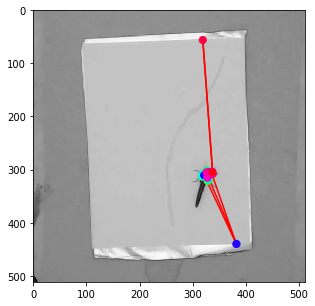

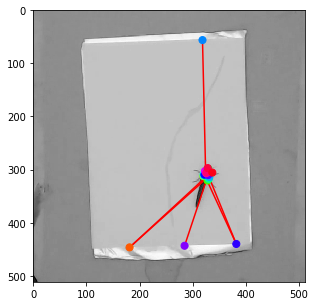

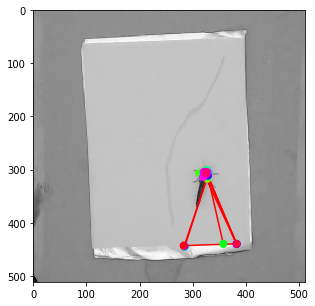

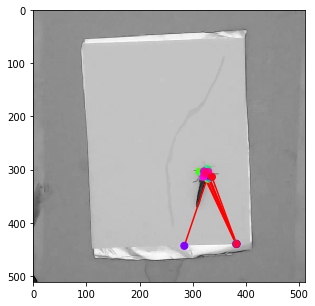

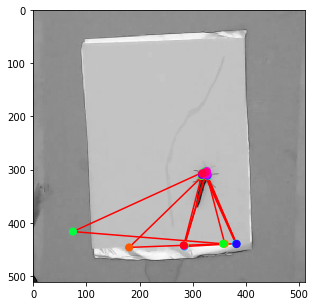

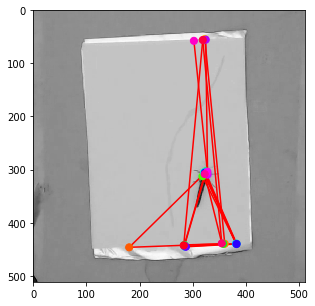

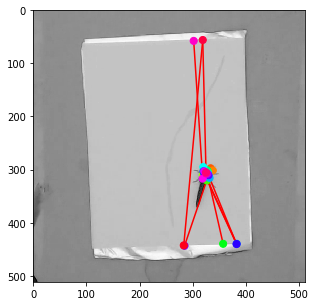

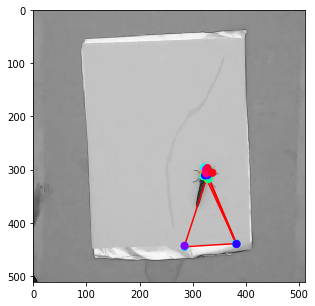

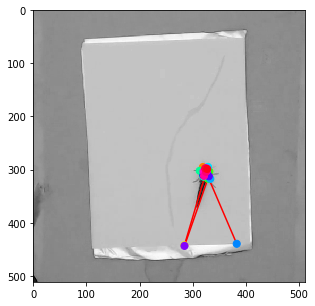

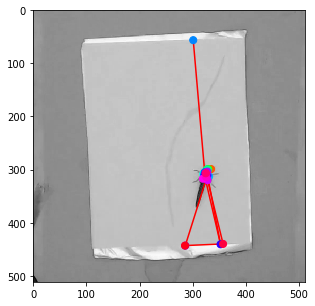

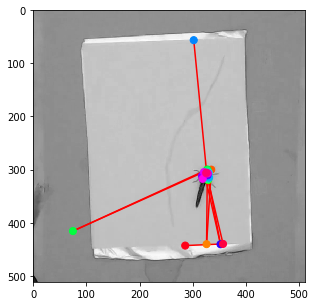

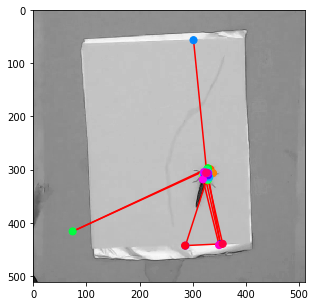

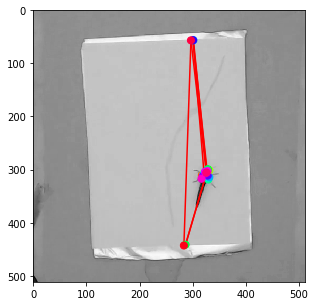

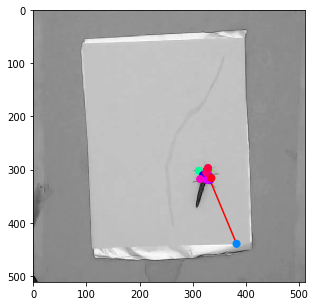

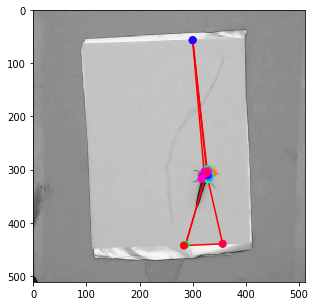

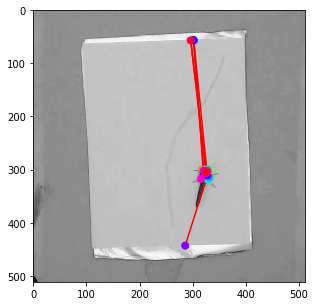

In [55]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/annotation_data_release.h5')

for idx in range(50):
    image = outlier_images[idx]
    keypoints = outlier_keypoints[idx]

    plt.figure(figsize=(5,5))
    image = image if image.shape[-1] is 3 else image[..., 0]
    cmap = None if image.shape[-1] is 3 else 'gray'
    plt.imshow(image, cmap=cmap, interpolation='none')
    for idx, jdx in enumerate(data_generator.graph):
        if jdx > -1:
            plt.plot(
                [keypoints[idx, 0], keypoints[jdx, 0]],
                [keypoints[idx, 1], keypoints[jdx, 1]],
                'r-'
            )
    plt.scatter(keypoints[:, 0], keypoints[:, 1],
                c=np.arange(data_generator.keypoints_shape[0]),
                s=50, cmap=plt.cm.hsv, zorder=3)

    plt.show()

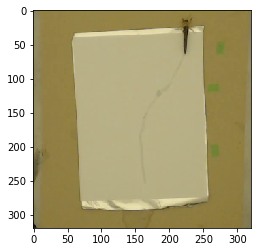

In [21]:
plt.imshow(frame[...,::-1])
plt.show()